# Chain Reaction: Uncovering Patterns in Bike-Sharing Usage  

### Description:  
The local government has launched a public bike-sharing system to reduce traffic congestion and promote sustainable transportation. As a data scientist, you're tasked with analyzing the usage patterns of this system. You have access to a dataset containing information about bike trips, including the date, time, start and end stations, and user information. Your mission is to uncover insights that will help optimize the system.

### Tasks:  
- **Riding by the Clock:** Calculate the average trip duration by day of the week and time of day.
- **Popular Pedals:** Identify the most popular bike routes and the number of trips taken on each route.
- **Lost in Transit:** Determine the percentage of users who fail to return bikes to designated stations.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import sys

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

Python version 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Pandas version 2.2.1
Numpy version 1.26.4


# The Data  

The dataset contains information about 1000 bike trips in a public bike-sharing system, including trip details. Some of the trips are missing end station information, indicating bikes not returned to designated stations.  

### Columns:  
- **Trip ID** - unique identifier
- **Start Date** - date of the trip
- **Start Time** - hour of the day
- **Start Station** - station where the trip started
- **End Station** - station where the trip ended, may be missing
- **Trip Duration** - length of the trip in minutes
- **Bike ID** - unique identifier for the bike

In [2]:
# set the seed
np.random.seed(0)

# create a date range
dates = pd.date_range('2024-01-01', '2024-01-31')

# generate random trip data
trips = pd.DataFrame({
    'Trip ID': range(1, 1001),
    'Start Date': np.random.choice(dates, 1000),
    'Start Time': np.random.randint(0, 24, 1000),
    'Start Station': np.random.choice(['A', 'B', 'C', 'D', 'E'], 1000),
    'End Station': np.random.choice(['F', 'G', 'H', 'I', 'J'], 1000)
})

# bikes not returned
trips.loc[np.random.choice(trips.index, 50), 'End Station'] = np.nan

# Add some additional columns
trips['Trip Duration'] = np.random.randint(1, 60, 1000)
trips['Bike ID'] = np.random.randint(1, 100, 1000)

trips.head()

,Trip ID,Start Date,Start Time,Start Station,End Station,Trip Duration,Bike ID
0,1,2024-01-13,18,A,I,43,83
1,2,2024-01-16,6,D,J,53,36
2,3,2024-01-22,20,D,J,7,85
3,4,2024-01-01,11,C,I,4,6
4,5,2024-01-04,22,B,J,41,59


Let us check the column data types before we begin task one.

In [3]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Trip ID        1000 non-null   int64         
 1   Start Date     1000 non-null   datetime64[ns]
 2   Start Time     1000 non-null   int32         
 3   Start Station  1000 non-null   object        
 4   End Station    951 non-null    object        
 5   Trip Duration  1000 non-null   int32         
 6   Bike ID        1000 non-null   int32         
dtypes: datetime64[ns](1), int32(3), int64(1), object(2)
memory usage: 43.1+ KB


# Riding by the Clock: 

Calculate the average trip duration by day of the week and time of day.

We can pull the day of the week by using `.dt.dayofweek`  

**Here is what the numbers mean:**  
- Monday = 0
- Tuesday = 1
- Wednesday = 2
- Thursday = 3
- Friday = 4
- Saturday = 5
- Sunday = 6

In [4]:
trips['Start Date'].dt.dayofweek.head()

0    5
1    1
2    0
3    0
4    3
Name: Start Date, dtype: int32

But it would be nicer if we were able to return the text representation of the day of the week.  

Fortunately, Pandas comes to the rescue with `.dt.day_name()`

In [5]:
trips['Day_of_Week'] = trips['Start Date'].dt.day_name()
trips.head()

,Trip ID,Start Date,Start Time,Start Station,End Station,Trip Duration,Bike ID,Day_of_Week
0,1,2024-01-13,18,A,I,43,83,Saturday
1,2,2024-01-16,6,D,J,53,36,Tuesday
2,3,2024-01-22,20,D,J,7,85,Monday
3,4,2024-01-01,11,C,I,4,6,Monday
4,5,2024-01-04,22,B,J,41,59,Thursday


Now we are ready to group by day of the week and time of day.

In [6]:
# create group object
group = trips.groupby(['Day_of_Week','Start Time'])

# calculate the average trip duration
group.mean(numeric_only=True)['Trip Duration']

Day_of_Week  Start Time
Friday       0             32.142857
             1             29.400000
             2             31.250000
             3             28.875000
             4             19.333333
                             ...    
Wednesday    19            29.500000
             20            34.000000
             21            15.400000
             22            19.333333
             23            30.500000
Name: Trip Duration, Length: 168, dtype: float64

# Popular Pedals:  

Identify the most popular bike routes and the number of trips taken on each route.

To accomplish this task, we really need to get a unique number of routes (Start Station - End Station) and then do a frequency count.

In [7]:
# create group object
group = trips.groupby(trips['Start Station'] + "-" + trips['End Station'])

# count the rows in the group and pull out the top 7
pop = group.count().sort_values(by='Trip ID', ascending=False)['Trip ID']
pop.head(7)

B-F    53
C-I    48
D-G    47
D-J    47
D-I    47
A-H    41
C-F    41
Name: Trip ID, dtype: int64

Looking at the histogram below, we can see that any route that has a frequency above 41 is rare.  

Using this chart, the most popular routes are (frequencies included):  
- B-F,    freq=53  
- C-I,    freq=48  
- D-G,    freq=47  
- D-J,    freq=47  
- D-I,    freq=47  

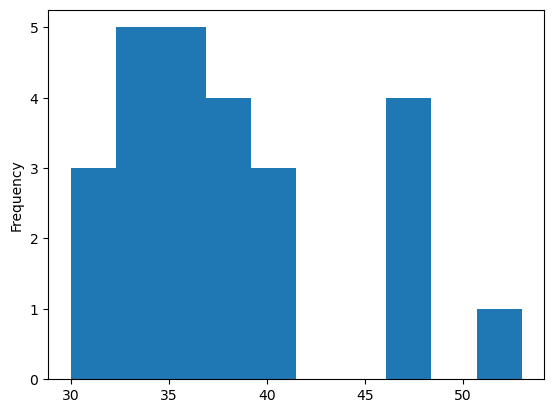

In [8]:
pop.plot.hist();

# Lost in Transit: 

Determine the percentage of users who fail to return bikes to designated stations.

This task should be a walk in the park for most of you. We are just counting the missing values under the "End Station" column and dividing it by the total count of the dataset.

In [9]:
(trips.loc[trips['End Station'].isnull(), 'End Station'].size / trips['End Station'].size) * 100

4.9

# Summary:  
The tutorial is based on a bike-sharing system dataset, which contains information about bike trips, including the date, time, start and end stations, and user information. The tasks include calculating the average trip duration by day of the week and time of day, identifying the most popular bike routes, and determining the percentage of users who fail to return bikes to designated stations.  

### Key Takeaways:  
- **Data Exploration:** The dataset is explored using various Pandas functions, including `info()`, `head()`, and dtypes.
- **Data Transformation:** The dataset is transformed by adding a new column for the day of the week using `dt.day_name()`.
- **GroupBy and Aggregation:** The dataset is grouped by day of the week and time of day, and the average trip duration is calculated using `groupby()` and `mean()`.
- **Data Analysis:** The most popular bike routes are identified by grouping and counting the routes, and the percentage of users who fail to return bikes is calculated using `isnull()` and size.
- **Data Visualization:** A histogram is plotted to visualize the frequency of bike routes.